# Формирование тестовой выборки

Имеются реальные данные малоуглового рассеяния нейтронов на липидных везикулах, полученные на спектрометре ЮМО. Данные будут использоваться в качестве тестовой выборки для оцененки качества модели. Сформируем датасет из этих данных. Сначала выполним загрузку данных, хранящихся в текстовых файлах, для чего напишем функцию. Поскольку файлы могут содержать "шапки" и заголовки разного размера (файлы были получены в разное время, с разными настройками программ обработки кривых и т.д.), выполним загрузку данных с определением формата файла в шапке.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from io import StringIO

In [ ]:
def data_loader(filename):

    with open(filename, 'r') as f:
        lines = f.readlines()

    data_lines = []
    for line in lines:
        line = line.strip()
        # Пропускаем пустые строки
        if not line:
            continue

        # Пробуем разбить строку на числа. Если не получилось преобразовать в числа, то это - шапка, поэтому пропускаем
        try:
            # Пробуем разные разделители. Нужно как минимум 2 столбца. Проверяем, что первый и второй элемент - числа.
            parts = line.split()
            if len(parts) >= 2:
                float(parts[0])
                float(parts[1])
                data_lines.append(line)
        except (ValueError, IndexError):
            continue

    # Загружаем данные из найденных числовых строк
    if data_lines:
        data_str = '\n'.join(data_lines)
        data = np.loadtxt(StringIO(data_str))
        return data



Визуализируем несколько случайных кривых рассеяния из выборки.

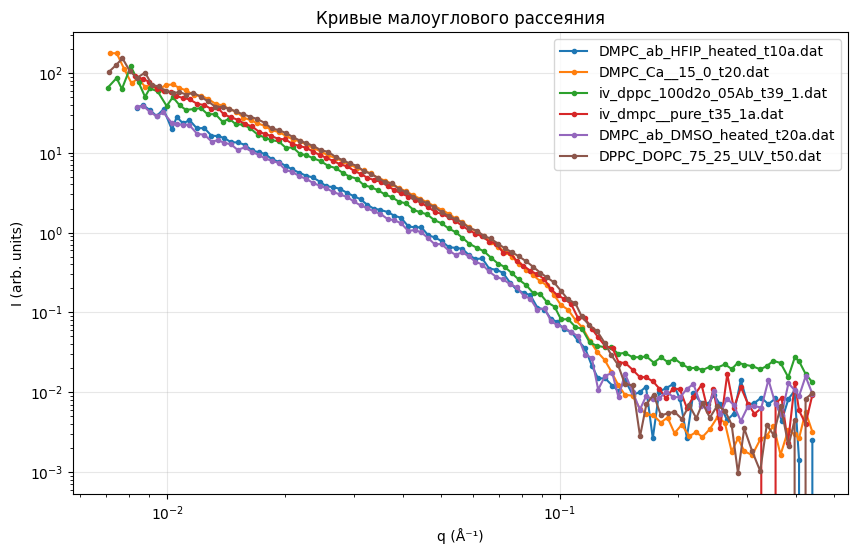

In [ ]:
def plot_sas(file_paths):
    plt.figure(figsize=(10, 6))

    for file_path in file_paths:

        data = data_loader(file_path)
        if data is not None:
            q = data[:, 0]
            I = data[:, 1]

            plt.loglog(q, I, 'o-', markersize=3, label=file_path)


    plt.xlabel('q (Å⁻¹)')
    plt.ylabel('I (arb. units)')
    plt.title('Кривые малоуглового рассеяния')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


all_files = [f for f in os.listdir("/content") if f.endswith('.dat')]
files = np.random.choice(all_files, 6, replace=False)


plot_sas(files)

Все реальные кривые малоуглового рассеяния для тестовой выборки имеют разный диапазон по q. Тем не менее, диапазон q тренировочных данных шире, и всегда охватывает диапазон по q реальных кривых для тестовой выборки. Чтобы тестовые кривые совпадали по q с тренировочными синтетическими кривыми рассеяния и подавались в модель единообразно, интерполируем данные на сетку, в которой пересекаются диапазоны всех тестовых кривых. Напишем функцию по пересечению диапазонов q для тестовых файлов.

In [ ]:
def find_common_q_range(files_directory):

    file_paths = list(Path(files_directory).glob("*.dat"))

    q_mins = []
    q_maxs = []

    for file_path in file_paths:
        try:
            data_array = data_loader(file_path)
            q_orig = data_array[:, 0]
            q_mins.append(q_orig.min())
            q_maxs.append(q_orig.max())
            print(f"{file_path.name}: q=[{q_orig.min():.6f}, {q_orig.max():.6f}]")
        except Exception as e:
            print(f"Ошибка загрузки {file_path}: {e}")
            continue

    # Пересечение = самый большой минимум и самый маленький максимум. Все файлы имеют данные от значения max(q_mins) и до значения max(q_mins)
    q_min_common = max(q_mins)
    q_max_common = min(q_maxs)

    print(f"q_min_common = {q_min_common:.6f}")
    print(f"q_max_common = {q_max_common:.6f}")

    return q_min_common, q_max_common

In [ ]:
q_min_common, q_max_common = find_common_q_range("/content")

DPPC_DOPC_1_1_ab_1_42_t20d.dat: q=[0.007069, 0.440730]
iv_dmpc__ab25_t60_1a.dat: q=[0.008294, 0.440730]
4iv_dppc_01ab42_100d2o_t38_1a.dat: q=[0.008372, 0.440730]
iv_dlpc__pure_t70_3a.dat: q=[0.008287, 0.440730]
DOPC_ULV_t50.dat: q=[0.007109, 0.440730]
iv_dppc_05Ab42_t40_2b.dat: q=[0.007149, 0.440730]
DMPC_pure_t50a_3.dat: q=[0.008359, 0.440730]
iv_dmpcA_Ab25_t40_1a.dat: q=[0.007107, 0.440730]
iv_dmpcB_Ab42_t70_1a.dat: q=[0.007106, 0.440730]
iv_dppc_05ab42_100d2o_t20_1a.dat: q=[0.008369, 0.440730]
DMPC_Mg__5_0_t20.dat: q=[0.007160, 0.440730]
iv_dppc_100d2o_00Ab_t30_2.dat: q=[0.007057, 0.440730]
iv_dmpc__ab25_t55_1a.dat: q=[0.008284, 0.440730]
DMPC_pure_t30b.dat: q=[0.008377, 0.440730]
iv_dppc_00ab42_100d2o_t36_1a.dat: q=[0.008382, 0.440730]
iv_dmpc__ab42_t65_1a.dat: q=[0.008292, 0.440730]
DPPC_DOPC_75_25_ULV_t50.dat: q=[0.007107, 0.440730]
DMPC_Ca__10_0_t20.dat: q=[0.007159, 0.440730]
kn03_DOPC_Mg__7_5.dat: q=[0.007115, 0.440730]
DMPC_DMSO_t25a.dat: q=[0.008375, 0.440730]
iv_dppc_01ab42

Создадим и сохраним датасет для тестовой выборки из файлов рассеяния. Для этого создадим общую сетку для всех файлов, произведем нормировку.

In [ ]:
def create_test_dataset(files_directory, output_filename="test_dataset.csv"):


    # Создаем сетку для всех файлов. Установим диапазон по q
    q_range_common = np.logspace(np.log10(q_min_common), np.log10(q_max_common), 100)
    print(f"Общая q-сетка: [{q_range_common[0]:.6f}, {q_range_common[-1]:.6f}]")

    data_list = []
    file_paths = list(Path(files_directory).glob("*.dat"))

    for file_path in file_paths:

        data_array = data_loader(file_path)

        # Диапазоны по q и I тестовых данных
        q_orig, I_orig = data_array[:, 0], data_array[:, 1]

        # Интерполяция на общую сетку
        I_interp = np.interp(q_range_common, q_orig, I_orig)

        # Нормировка интенсивностей в соответствие с тренировочным набором данных
        if I_interp[0] > 0:
            I_interp = I_interp * (300 / I_interp[0])

        data_list.append({
            'filename': file_path.name,
            'q_angstrom': q_range_common,
            'I': I_interp,
            'errors_I': data_array[:, 2] if data_array.shape[1] > 2 else np.zeros(len(data_array))
        })



    # Создаем датасет
    df = pd.DataFrame(data_list)

    # Сохраним
    df.to_csv(output_filename, index=False)
    print(f"Датасет сохранен")
    print(f"Обработано файлов: {len(data_list)}")

    return df


In [ ]:
test_df = create_test_dataset("/content", output_filename="test_dataset.csv")

Общая q-сетка: [0.008389, 0.440700]
Датасет сохранен
Обработано файлов: 501


Таким образом, в тестовой выборке 501 файл, для которых создано общее пересечение диапазона q.

In [ ]:
display(test_df.head())
display(test_df.tail())


,filename,q_angstrom,I,errors_I
0,DPPC_DOPC_1_1_ab_1_42_t20d.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 275.30394513895726, 269.1396236570938,...","[54.506, 74.01, 42.771, 51.226, 26.165, 25.277..."
1,iv_dmpc__ab25_t60_1a.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 289.8927265115577, 262.6816132072297, ...","[13.612, 12.045, 14.052, 8.1749, 8.8948, 7.124..."
2,4iv_dppc_01ab42_100d2o_t38_1a.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 202.74589234990134, 190.72776659187917...","[82.269, 33.47, 37.588, 25.086, 16.338, 20.477..."
3,iv_dlpc__pure_t70_3a.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 272.14058227998436, 241.67747258683664...","[10.055, 8.2533, 9.3694, 5.5656, 6.0605, 4.984..."
4,DOPC_ULV_t50.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 319.95604366450345, 247.33110411508213...","[29.649, 40.027, 51.508, 27.596, 20.824, 26.36..."


,filename,q_angstrom,I,errors_I
496,DMPC_ab_HFIP_heated_t26d.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 331.8999444096924, 275.942259666481, 3...","[9.9166, 10.295, 8.7394, 8.4181, 9.5057, 4.653..."
497,DMPC_DMSO_t30b.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 305.02618911774226, 296.30035037407015...","[8.7926, 8.1954, 8.2233, 7.294, 8.0241, 4.8012..."
498,iv_dlpc__ab42_t55_1a.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 259.502199737539, 227.78453733297042, ...","[11.416, 8.8959, 9.9503, 5.8991, 6.1189, 5.070..."
499,iv_dspc__ab25_t30_1a.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 288.57450702107593, 247.4055085435249,...","[10.756, 8.7068, 10.319, 7.8069, 7.211, 7.1737..."
500,iv_dppc_05Ab42_t45_1a.dat,"[0.0083886, 0.008731076730949179, 0.0090875355...","[300.0, 164.77967424894825, 128.44087048562267...","[100.39, 29.517, 92.275, 57.225, 73.582, 25.78..."


Загрузим файл с информацией по толщине липидных мембран для соответствующих кривых. Этот файл был получен на основе фитирования этих кривых малоуглового рассеяния в программной утилите Sasview.

In [ ]:
thickness_df = pd.read_csv('/content/fits_results.csv').reset_index()

In [ ]:
display(thickness_df.head())
display(thickness_df.tail())

,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,File Generated by SasView : Fittingon Nov 26 13;15 of 2025.
0,scale,Chi2,sld_solvent,thickness,radius,volfraction,background,sld,Data,NaN
1,0.131992612868,1.34322465006,6.36,44.6714541171,558.835116959,0.05,0.0140706415952,0.5,4iv_dppc_01ab42_100d2o_t34_1a.dat,NaN
2,0.132835723576,0.971224587801,6.36,44.2370422123,429.268229081,0.05,0.0146126746551,0.5,4iv_dppc_01ab42_100d2o_t36_1a.dat,NaN
3,0.132596599125,1.09563562133,6.36,43.8503065909,492.963227749,0.05,0.0148677825984,0.5,4iv_dppc_01ab42_100d2o_t36_1b.dat,NaN
4,0.12452082806,1.05432232793,6.36,43.7010414108,483.853224262,0.05,0.00569423318397,0.5,4iv_dppc_01ab42_100d2o_t38_1a.dat,NaN


,level_0,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,File Generated by SasView : Fittingon Nov 26 13;15 of 2025.
497,0.323436888347,2.64340708867,6.36,38.7938488429,487.194898584,0.05,0.0147020552397,0.5,ks_popc_200Mg.dat,NaN
498,0.330442322621,1.47025002265,6.36,38.1175652331,437.381166136,0.05,0.0150551224572,0.5,ks_popc_300Ca.dat,NaN
499,0.330679085085,1.65450902427,6.36,38.0311191333,495.756635316,0.05,0.016298173757,0.5,ks_popc_300Mg.dat,NaN
500,0.32065100933,1.38056077749,6.36,37.77903762,496.150595199,0.05,0.0151591434917,0.5,ks_popc_500Ca.dat,NaN
501,0.318541251596,1.8101674445,6.36,38.1491779251,515.12535499,0.05,0.0184280735992,0.5,ks_popc_500Mg.dat,NaN


Переименуем названия столбцов, сбросим индексы.

In [ ]:
thickness_df = thickness_df.rename(columns=thickness_df.iloc[0])

thickness_df = thickness_df.iloc[1:, :9].reset_index(drop=True)

display(thickness_df.head())
display(thickness_df.info())

,scale,Chi2,sld_solvent,thickness,radius,volfraction,background,sld,Data
0,0.131992612868,1.34322465006,6.36,44.6714541171,558.835116959,0.05,0.0140706415952,0.5,4iv_dppc_01ab42_100d2o_t34_1a.dat
1,0.132835723576,0.971224587801,6.36,44.2370422123,429.268229081,0.05,0.0146126746551,0.5,4iv_dppc_01ab42_100d2o_t36_1a.dat
2,0.132596599125,1.09563562133,6.36,43.8503065909,492.963227749,0.05,0.0148677825984,0.5,4iv_dppc_01ab42_100d2o_t36_1b.dat
3,0.12452082806,1.05432232793,6.36,43.7010414108,483.853224262,0.05,0.00569423318397,0.5,4iv_dppc_01ab42_100d2o_t38_1a.dat
4,0.158992884177,4.90999424422,6.36,39.7217075495,505.651892626,0.05,0.000796269130716,0.5,DMPC_Ca__10_0_t20.dat


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   scale        501 non-null    object
 1   Chi2         501 non-null    object
 2   sld_solvent  501 non-null    object
 3   thickness    501 non-null    object
 4   radius       501 non-null    object
 5   volfraction  501 non-null    object
 6   background   501 non-null    object
 7   sld          501 non-null    object
 8   Data         501 non-null    object
dtypes: object(9)
memory usage: 35.4+ KB


None

В этом файле количество объектов совпадает с количеством объектов файла, рассмотренного выше, поэтому далее будет выполнено простое объединение этих датасетов.  


Изменим тип данных, переименуем названия столбцов и удалим ненужные столбцы.

In [ ]:
thickness_df[['thickness']] = thickness_df[['thickness']].astype(float)

thickness_df = thickness_df.rename(columns={'Data': 'filename', 'thickness': 'thickness_fitted', 'radius': 'radius_fitted'})

thickness_df = thickness_df.drop(['volfraction', 'sld', 'sld_solvent'], axis=1)

In [ ]:
thickness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   scale             501 non-null    object 
 1   Chi2              501 non-null    object 
 2   thickness_fitted  501 non-null    float64
 3   radius_fitted     501 non-null    object 
 4   background        501 non-null    object 
 5   filename          501 non-null    object 
dtypes: float64(1), object(5)
memory usage: 23.6+ KB


Объединим 2 датасета, тем самым совершив разметку данных, и сохраним результат.



In [ ]:
merged_df = test_df.merge(thickness_df, on='filename', how='inner')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   filename          501 non-null    object 
 1   q_angstrom        501 non-null    object 
 2   I                 501 non-null    object 
 3   errors_I          501 non-null    object 
 4   scale             501 non-null    object 
 5   Chi2              501 non-null    object 
 6   thickness_fitted  501 non-null    float64
 7   radius_fitted     501 non-null    object 
 8   background        501 non-null    object 
dtypes: float64(1), object(8)
memory usage: 35.4+ KB


In [ ]:
merged_df.to_csv('dataset_for_test.csv', index=False)

В данной части работы были рассмотрены кривые малоуглового рассеяния нейтронов на липидных везикулах, полученные на спектрометре ЮМО и предназначенные для тестовой выборки. Определено пересечение кривых по диапазону переданного импульса q (q = [0.008389, 0.440700]). Данные были натянуты на сетку и интерполированы так, чтобы соответствовать q-диапазону в тренировочных синтетических данных. Произведена нормировка кривых. Датасет с результатами фитирования этих кривых, полученный ранее, был соединен непосредственно с данными рассеяния для того, чтобы сформировать единый датасет для оценки качества модели.